./IMG/center_2018_01_02_23_25_25_433.jpg
./IMG/center_2018_01_02_23_25_25_900.jpg


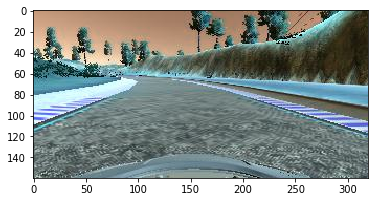

In [19]:
import csv
import cv2
import matplotlib.pyplot as plt

lines = []
with open('./driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

images = []
measurements = []
for line in lines[1:3]:
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = './IMG/' + filename
    print(current_path)
    images.append(cv2.imread(current_path))
    measurements.append(float(line[3]))



In [20]:
from keras.models import Sequentail
from keras.layers import Flatten, Dense

ImportError: No module named keras.models